## Retrievability Experiment

Retrievability experiment and analysis of TREC678 corpus

In this version v1, I do query generation as per Azzopardi's CIKM'08 paper. I get ~ 1M queries unigram and bigrams combined. Then, I perform retrievals and find retrievability of each doc. Then, plot Lorenz curve and compute Gini coefficient and Pearson's correlation coefficient. 
Then, as asked by sir, I look into retrievability of judged docs in contrast with all docs. Summary Statistics showed that, though judged docs spread over min to max r(d) values, mean judged docs r(d) is significantly greater than mean r(d) for all docs.

Steps -
* Generate query set Q containing unigram and bigram queries from the corpus
* Perform retrieval for all queries q $\in$ Q. If document d present within cutoff rank, then increament r(d) by 1.

In [ ]:
# quert set Q divided into unigram queries and bigram queries
# unigram queries are the corpus vocabulary terms which has tf>=5
# vocab terms and their tf from lucene index
# filter tf on the fly and add terms into a list

# For bigram queries, use corpus doc generator class from doc2vec training code
# From each doc, take bigrams and try adding them to a dictionary
# if key found, add 1 to its value; if key not found, then add key into dict with value=1
# this dict is bigram,tf pair
# sort dict by tf in reverse order
# take first 2 million bigram and make a list of these bigrams

# write query set on disk for record

# run loop over unigram and bigram queries
# do BM25 retrieval of top c(=100) ranks for each query
# iterate over top c docs and try adding them into r(d) dict
# if key found, add 1 to its value; if key not found, then add key into dict with value=1
# this dict is docid,occurenceCount
# sort dict by value in ascending order

# write r(d) dict on disk for record

# plot Lorenz curve
# compute Gini Coefficient G


In [1]:
import lucene
from org.apache.lucene.search import IndexSearcher
from org.apache.lucene.index import DirectoryReader
from org.apache.lucene.index import MultiTerms
from org.apache.lucene.store import FSDirectory
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.search.similarities import BM25Similarity
from org.apache.lucene.search.similarities import ClassicSimilarity
from org.apache.lucene.search.similarities import LMJelinekMercerSimilarity
from org.apache.lucene.search.similarities import LMDirichletSimilarity
from org.apache.lucene.analysis.en import EnglishAnalyzer
from java.io import File

from org.apache.lucene.search import BooleanQuery
from org.apache.lucene.search import BooleanClause
from org.apache.lucene.search import TermQuery
from org.apache.lucene.search import BoostQuery
from org.apache.lucene.index import Term

from org.apache.lucene.util import BytesRefIterator

In [2]:
# run this again if VM is not initialized already
lucene.initVM()

In [3]:
# Lucene index of the corpus
index_path = '../index/'
directory = FSDirectory.open(File(index_path).toPath())
indexReader = DirectoryReader.open(directory)

FIELDNAME = 'CONTENT'       # Lucene index field name

### Query Generation

In [4]:
unigram_queries = []

terms = MultiTerms.getTerms(indexReader, FIELDNAME)
iterator = terms.iterator()

for term in BytesRefIterator.cast_(iterator):
    term_str = term.utf8ToString()
    t = Term(FIELDNAME, term_str)
    if not term_str.isalpha():
        continue
    tf = indexReader.totalTermFreq(t)
    if tf >= 5:
        unigram_queries.append(term_str)

print(len(unigram_queries))

153703


In [5]:
# write unigram_queries to disk
with open('./unigram_queries_onlyAlpha_tf5.txt', 'w') as f:
    f.write('\n'.join(unigram_queries))
    f.write('\n')

In [7]:
import smart_open

class MyCorpus:
    def __init__(self, corpusDirectory):
        import os
        # Corpus documents directory path
        self.dirPath = corpusDirectory
        self.fileNames = os.listdir(self.dirPath)
        self.filePaths = [f'{self.dirPath}/{f}' for f in self.fileNames]
        self.docCount = 0
    
    def __iter__(self):
        import re
        tag_exp = re.compile('<.*?>')

        def cleanTag(rawDoc):
            cleanDoc = re.sub(tag_exp, '', rawDoc)
            return cleanDoc

        def process(oneDoc):
            # global docCount
            self.docCount += 1
            # print(docCount, docid)   # weirdly, printing docid was contributing to RAM overflow
            # print(docCount)
            return cleanTag(oneDoc)
        
        # this function needs to be called for each of the files in the directory
        def processFile(filePath):
            with smart_open.open(filePath, 'r', encoding='ISO-8859-1') as f:
                inDoc = False
                docid,oneDoc = "",""
                docCounts,docids,contents = [],[],[]     # will store all the docs (docIDs, Contents) of a single file in a list
                                            # with docid and contents in one-to-one list index-wise correspondence
                                            # Why making lists? See the note in the next cell.
                for line in f:
                    if inDoc:
                        if line.startswith("<DOCNO>"):
                            m = re.search('<DOCNO>(.+?)</DOCNO>', line)
                            docid = m.group(1)
                            continue
                        elif line.strip() == "</DOC>":
                            inDoc = False
                            contents.append(process(oneDoc))
                            docCounts.append(self.docCount)
                            docids.append(docid.strip())
                            oneDoc = ""
                        else:
                            oneDoc += line

                    elif line.strip() == "<DOC>":
                        inDoc = True
                # return docids,contents
                return docCounts,contents
        
        for filePath in self.filePaths:
            integer_ids,contents = processFile(filePath)
            for i in range(len(integer_ids)):
                yield contents[i]

In [10]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.regexp import blankline_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter

# Corpus documents directory path
dirPath = '../../TREC_67/documents_robust04/'
trec_corpus = MyCorpus(corpusDirectory=dirPath)

bigram_counter = Counter()      # to store bigrams with their frequencies

stop_words = stopwords.words('english')
stop_words.extend(["'s"])
stopwords_set = set(stop_words)

count_doc = 0
for doc in trec_corpus:
    count_doc += 1
    # text pre-processing:
    # blankline tokenization, then sentence tokenization, then word tokenization
    sents_nested = [sent_tokenize(ss) for ss in blankline_tokenize(doc)]
    sents = [sent for sublist in sents_nested for sent in sublist]
    tokens_nested = [word_tokenize(s) for s in sents]
    # stopword removal and all char non-alphanumeric token removal
    tokens_nested = [[token for token in tokens if any(char.isalnum() for char in token) and token.lower() not in stopwords_set] for tokens in tokens_nested]
    # bigram sampling one sentence at a time
    for tokens in tokens_nested:
        bi_grams = ngrams(tokens, 2)
        bigram_counter.update(bi_grams)
    # stdout count_doc logging
    if count_doc%10000==0:
        print(f'upto #doc = {count_doc}')

print(f'\nNumber of docs covered during bigram sampling = {count_doc}')

limit = 2000000     # 2 million -> #bigram limit
bigram_list = sorted([x for x in bigram_counter.items() if x[1]>=20], reverse=True, key=lambda lst: lst[1])[:limit]
bigram_queries = [' '.join(x[0]) for x in bigram_list]

upto #doc = 10000
upto #doc = 20000
upto #doc = 30000
upto #doc = 40000
upto #doc = 50000
upto #doc = 60000
upto #doc = 70000
upto #doc = 80000
upto #doc = 90000
upto #doc = 100000
upto #doc = 110000
upto #doc = 120000
upto #doc = 130000
upto #doc = 140000
upto #doc = 150000
upto #doc = 160000
upto #doc = 170000
upto #doc = 180000
upto #doc = 190000
upto #doc = 200000
upto #doc = 210000
upto #doc = 220000
upto #doc = 230000
upto #doc = 240000
upto #doc = 250000
upto #doc = 260000
upto #doc = 270000
upto #doc = 280000
upto #doc = 290000
upto #doc = 300000
upto #doc = 310000
upto #doc = 320000
upto #doc = 330000
upto #doc = 340000
upto #doc = 350000
upto #doc = 360000
upto #doc = 370000
upto #doc = 380000
upto #doc = 390000
upto #doc = 400000
upto #doc = 410000
upto #doc = 420000
upto #doc = 430000
upto #doc = 440000
upto #doc = 450000
upto #doc = 460000
upto #doc = 470000
upto #doc = 480000
upto #doc = 490000
upto #doc = 500000
upto #doc = 510000
upto #doc = 520000

Number of docs cover

In [11]:
# write bigram_queries to disk
with open('./bigram_queries.txt', 'w') as f:
    f.write('\n'.join(bigram_queries))
    f.write('\n')

In [12]:
len(bigram_queries)

797452

### Retrievals and estimating Document Retrievability

In [4]:
import pickle
from collections import Counter

def retrievability_experiment(similarityModel, corpusIndexPath, c, query_files_num_queries):
    directory = FSDirectory.open(File(corpusIndexPath).toPath())
    searcher = IndexSearcher(DirectoryReader.open(directory))
    searcher.setSimilarity(similarityModel)
    
    r_d = Counter()     # to store lucene_docids and their cumulative counts
    
    def retrieve(query, c, r_d):
        escaped_q = QueryParser('CONTENT', analyzer).escape(query)
        q = QueryParser('CONTENT', analyzer).parse(escaped_q)

        # getting the top c search results using the searcher
        scoreDocs = searcher.search(q, c).scoreDocs

        lucene_docids = []
        for scoreDoc in scoreDocs:
            lucene_docids.append(scoreDoc.doc)

        r_d.update(lucene_docids)
    
    for item in query_files_num_queries:
        filePath = item[0]
        len_queries = item[1]
        query_type = ' '.join(filePath[2:-4].split('_')).capitalize()
        
        print(f"{query_type} run starts...")
        with open(filePath) as f:
            i = 0
            for line in f:
                query = line[:-1]
                retrieve(query, c, r_d)
                
                i += 1
                if i%round(len_queries/20)==0:
                    print(f"{query_type} progress... {i*100/len_queries: .2f}%")
            print(f'Run completed with {query_type} progress... {i*100/len_queries: .2f}%')

    with open(f'./rd_{c}_{model}.pickle', 'wb') as f:
        pickle.dump(r_d, f)
        
    return r_d

In [5]:
# Retrievability Experiment for various cutoff rank c

# setting up the searcher
analyzer = EnglishAnalyzer()    # used same analyzer as indexer

model = 'lmdir'
# k1 = 0.8; b = 0.4
mu = 1000.0
similarityModel = LMDirichletSimilarity(mu)   # LM with Bayes Smoothing Dirchlet Similarity

query_set_files = ['./unigram_queries.txt', './bigram_queries.txt']
query_files_num_queries = [(path, sum(1 for _ in open(path))) for path in query_set_files]  # [('filename.txt',num_of_queries)]

all_rd = dict()
for c in [10,20,30,50,100]:
    print(f'Retrievals starting for c = {c}\n')
    all_rd[f'r_d_{c}'] = retrievability_experiment(similarityModel,index_path,c,query_files_num_queries)
    print(f'Completed! c = {c}\n')

Retrievals starting for c = 50

Unigram queries run starts...
Unigram queries progress...  5.00%
Unigram queries progress...  10.00%
Unigram queries progress...  15.00%
Unigram queries progress...  20.00%
Unigram queries progress...  25.00%
Unigram queries progress...  30.00%
Unigram queries progress...  35.00%
Unigram queries progress...  40.00%
Unigram queries progress...  45.00%
Unigram queries progress...  50.00%
Unigram queries progress...  55.00%
Unigram queries progress...  60.00%
Unigram queries progress...  65.00%
Unigram queries progress...  70.00%
Unigram queries progress...  75.00%
Unigram queries progress...  80.00%
Unigram queries progress...  85.00%
Unigram queries progress...  90.00%
Unigram queries progress...  95.00%
Unigram queries progress...  100.00%
Run completed with Unigram queries progress...  100.00%
Bigram queries run starts...
Bigram queries progress...  5.00%
Bigram queries progress...  10.00%
Bigram queries progress...  15.00%
Bigram queries progress...  2

In [3]:
with open('./rd.pickle', 'rb') as f:
    r_d = pickle.load(f)

In [35]:
from operator import itemgetter

N = 528155      # No. of docs in Corpus
for num in range(N):
    r_d[num] = r_d.get(num, 0)

r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))       # r(d) is ascending order with lucene-docids

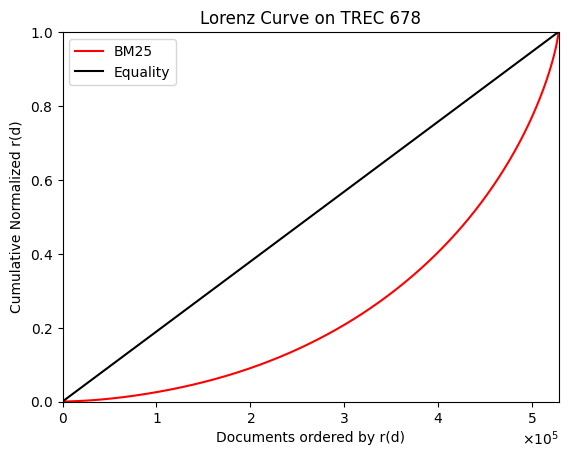

In [66]:
# Lorenz Curve of r(d) scores

import matplotlib.pyplot as plt
import numpy as np

X = np.arange(len(r_d_sorted))    # No. of docs
Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
Y = Y/np.max(Y)
equality = np.cumsum(np.full(len(r_d_sorted), 1.0/len(r_d_sorted)))

plt.plot(X,Y,'-', label='BM25', color='r')
plt.plot(X,equality,'-', label='Equality', color='black')
plt.legend(loc='upper left')
plt.title('Lorenz Curve on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./lorenz_curve_bm25_c=100.png', facecolor='white', transparent=False, dpi=300)
plt.show()

In [45]:
# Gini Coefficient G

N = 528155      # No. of docs in Corpus

G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
print(f'Gini Coefficient, G = {G:.4f}')

Gini Coefficient, G = 0.5031


BM25, c = 10: Gini Coefficient, G = 0.6139
BM25, c = 20: Gini Coefficient, G = 0.5768
BM25, c = 30: Gini Coefficient, G = 0.5567
BM25, c = 50: Gini Coefficient, G = 0.5329
BM25, c = 100: Gini Coefficient, G = 0.5031


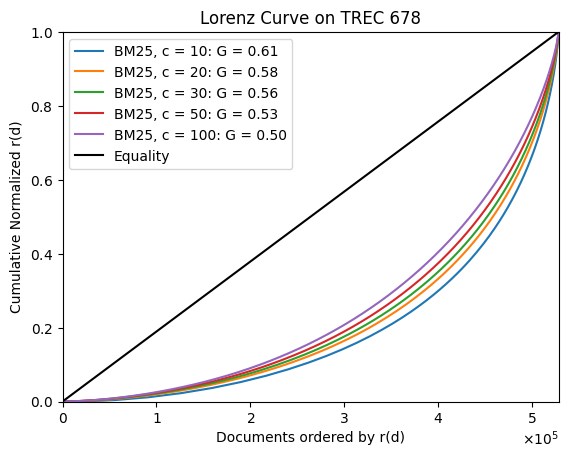

In [46]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt


N = 528155      # No. of docs in Corpus
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))
c_list  = [10,20,30,50,100]

model = 'bm25'

all_rd = {}
for c in c_list:
    with open(f'./rd_{c}_{model}.pickle', 'rb') as f:
        all_rd[f'r_d_{c}'] = pickle.load(f)

for c in c_list:
    
    r_d = all_rd[f'r_d_{c}']
    
    # setting non-retrieved documents' retrieval count to zero and including them in r_d
    for num in range(N):
        r_d[num] = r_d.get(num, 0)

    r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
    print(f'{model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    plt.plot(X,Y,'-', label=f'{model.upper()}, c = {c}: G = {G:.2f}')
    
plt.plot(X,equality,'-', label='Equality', color='black')
plt.legend(loc='upper left')
plt.title('Lorenz Curve on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./lorenz_curve_{model}.png', facecolor='white', transparent=False, dpi=300)
plt.show()

In [47]:
# Pearson's Correlation Coefficient, \rho

import scipy

print("Pearson's Correlation Coefficient (rho) calculation\n")
for c1 in c_list:
    for c2 in c_list:
        if c1 == c2: continue
        
        r_d_c1 = all_rd[f'r_d_{c1}']
        r_d_c2 = all_rd[f'r_d_{c2}']
        
        # setting non-retrieved documents' retrieval count to zero and including them in r_d
        for num in range(N):
            r_d_c1[num] = r_d_c1.get(num, 0)
            r_d_c2[num] = r_d_c2.get(num, 0)

        # r_d_c1_sorted = sorted(r_d_c1.most_common(), key=itemgetter(1))    # r(d) is ascending order with lucene-docids
        # r_d_c2_sorted = sorted(r_d_c2.most_common(), key=itemgetter(1))    # r(d) is ascending order with lucene-docids
        
        # r_d_c1_sorted = [x[1] for x in r_d_c1_sorted]
        # r_d_c2_sorted = [x[1] for x in r_d_c2_sorted]
        
        r_d_c1_vals = [r_d_c1[key] for key in range(N)]
        r_d_c2_vals = [r_d_c2[key] for key in range(N)]
        
        rho, pval = scipy.stats.pearsonr(r_d_c1_vals, r_d_c2_vals)
        # rho, pval = scipy.stats.pearsonr(r_d_c1_sorted, r_d_c2_sorted)
        print(f'{model.upper()}, c-pair=({c1},{c2}): rho = {rho:.4f}\tp-value = {pval}')

Pearson's Correlation Coefficient (rho) calculation

BM25, c-pair=(10,20): rho = 0.9757	p-value = 0.0
BM25, c-pair=(10,30): rho = 0.9537	p-value = 0.0
BM25, c-pair=(10,50): rho = 0.9186	p-value = 0.0
BM25, c-pair=(10,100): rho = 0.8592	p-value = 0.0
BM25, c-pair=(20,10): rho = 0.9757	p-value = 0.0
BM25, c-pair=(20,30): rho = 0.9897	p-value = 0.0
BM25, c-pair=(20,50): rho = 0.9668	p-value = 0.0
BM25, c-pair=(20,100): rho = 0.9200	p-value = 0.0
BM25, c-pair=(30,10): rho = 0.9537	p-value = 0.0
BM25, c-pair=(30,20): rho = 0.9897	p-value = 0.0
BM25, c-pair=(30,50): rho = 0.9869	p-value = 0.0
BM25, c-pair=(30,100): rho = 0.9508	p-value = 0.0
BM25, c-pair=(50,10): rho = 0.9186	p-value = 0.0
BM25, c-pair=(50,20): rho = 0.9668	p-value = 0.0
BM25, c-pair=(50,30): rho = 0.9869	p-value = 0.0
BM25, c-pair=(50,100): rho = 0.9802	p-value = 0.0
BM25, c-pair=(100,10): rho = 0.8592	p-value = 0.0
BM25, c-pair=(100,20): rho = 0.9200	p-value = 0.0
BM25, c-pair=(100,30): rho = 0.9508	p-value = 0.0
BM25, c-p

Is there significant overlap between judged documents and documents with high retrievability score?
Or, Is the mean of r(d) of judged documents significantly higher than the global mean of r(d)?
Also, plot ascending r(d)

In [ ]:
# DOCID to lucene_docID dict mapping
searcher = IndexSearcher(DirectoryReader.open(directory))
docid_to_luceneID_dict = {}
for i in range(N):
    docid_to_luceneID_dict[searcher.doc(i).get('DOCID')] = i
    if (i+1)%10000==0:
        print('Upto ',i+1)
print('complete!')

with open(f'./DOCID_to_lucene-docID_dict.pickle', 'wb') as f:
        pickle.dump(docid_to_luceneID_dict, f)

In [8]:
import pickle

with open('./rd_dumps/rd_queryset2_bm25_100.pickle', 'rb') as f:
    r_d = pickle.load(f)
    
with open('./DOCID_to_lucene-docID_dict.pickle', 'rb') as f:
    docid_to_luceneID_dict = pickle.load(f)

N = 528155
for num in range(N):
    r_d[num] = r_d.get(num, 0)

In [9]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt

qrelFilePath = '/archive/trec678_robust.qrel'

judgeDocSet = set()
with open(qrelFilePath, 'r') as f:
    for line in f:
        l = line.split()
        qid, docid, judgement = l[0], l[2], int(l[3])
        lucene_docID = docid_to_luceneID_dict[docid]
        judgeDocSet.add(lucene_docID)

# now taking lucene_docID from judgeDocSet as key in r_d, get the r_d scores of all the judged docs
judged_rd = [(ldocid, r_d[ldocid]) for ldocid in judgeDocSet]
judged_rd_sorted = sorted(judged_rd, key=itemgetter(1))    # r(d) in ascending order with lucene-docids

non_judged_rd = [(ldocid, r_d[ldocid]) for ldocid,_ in r_d.most_common() if ldocid not in judgeDocSet]
non_judged_rd_sorted = sorted(non_judged_rd, key=itemgetter(1))    # r(d) in ascending order with lucene-docids

r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids

non_judged_rd_vals = [x[1] for x in non_judged_rd_sorted]
r_d_judged_vals = [x[1] for x in judged_rd_sorted]

In [10]:
r_d_docids = {r_d_sorted[i][0]:i for i in range(len(r_d_sorted))}
X1 = [r_d_docids[docid] for docid in [x[0] for x in non_judged_rd_sorted]]
X2 = [r_d_docids[docid] for docid in [x[0] for x in judged_rd_sorted]]

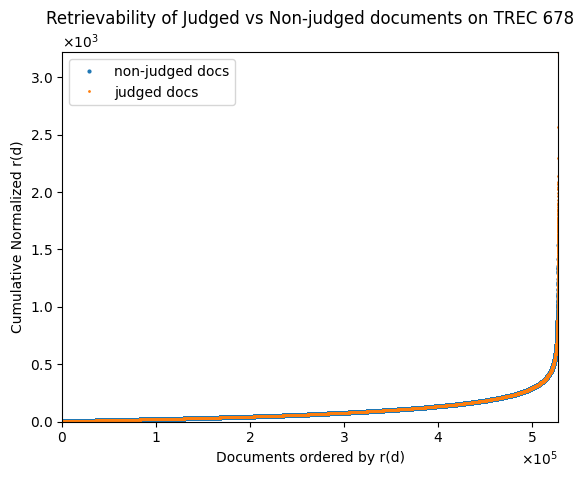

In [13]:
plt.plot(X1, non_judged_rd_vals, 'o', markersize=2, label='non-judged docs')
plt.plot(X2, r_d_judged_vals, 'o', markersize=1, label='judged docs')
plt.legend(loc='upper left')
plt.title('Retrievability of Judged vs Non-judged documents on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./judged_vs_nonjudged_bm25_100.png', facecolor='white', transparent=True, dpi=300)
plt.show()

In [16]:
print(f'Mean of r(d) of non-judged docs = {np.mean(non_judged_rd_vals):.4f}\nMean of r(d) of only judged docs = {np.mean(r_d_judged_vals):.4f}')

Mean of r(d) of non-judged docs = 80.1496
Mean of r(d) of only judged docs = 131.0304


In [18]:
import pandas as pd

nonjudged_docs = pd.Series(non_judged_rd_vals)
judged_docs = pd.Series(r_d_judged_vals)

print(f'Summary Statistics of r(d) values of non-judges docs:\n{nonjudged_docs.describe()}\n')
print(f'Summary Statistics of r(d) values of only judged docs:\n{judged_docs.describe()}')

Summary Statistics of r(d) values of non-judges docs:
count    353368.000000
mean         80.149623
std          86.208800
min           0.000000
25%          24.000000
50%          52.000000
75%         106.000000
max        1534.000000
dtype: float64

Summary Statistics of r(d) values of only judged docs:
count    174787.000000
mean        131.030374
std         139.208288
min           0.000000
25%          39.000000
50%          93.000000
75%         177.000000
max        3220.000000
dtype: float64


BM25, c = 100: Gini Coefficient, G = 0.5031
TFIDF, c = 100: Gini Coefficient, G = 0.5325
LMDIR, c = 100: Gini Coefficient, G = 0.6214


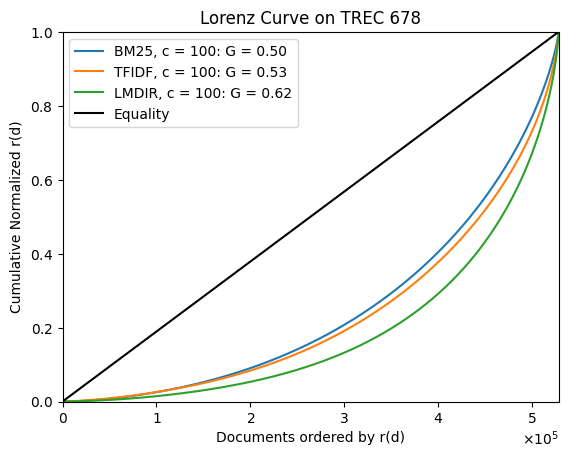

In [45]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt


N = 528155      # No. of docs in Corpus
X = np.arange(N)    # No. of docs array
equality = np.cumsum(np.full(N, 1.0/N))
c = 100

model1 = 'bm25'
model2 = 'tfidf'
model3 = 'lmdir'
models = [model1, model2, model3]

all_rd = {}
for model in models:
    with open(f'./rd_{c}_{model}.pickle', 'rb') as f:
        all_rd[f'r_d_{model}'] = pickle.load(f)

for model in models:
    
    r_d = all_rd[f'r_d_{model}']
    
    # setting non-retrieved documents' retrieval count to zero and including them in r_d
    for num in range(N):
        r_d[num] = r_d.get(num, 0)

    r_d_sorted = sorted(r_d.most_common(), key=itemgetter(1))    # r(d) in ascending order with lucene-docids
    
    # Gini Coefficient G
    G = sum([(2*i-N-1)*r_d_sorted[i-1][1] for i in range(1,N+1)])/(N*sum([r_d_sorted[j-1][1] for j in range(1,len(r_d_sorted)+1)]))
    print(f'{model.upper()}, c = {c}: Gini Coefficient, G = {G:.4f}')

    # Lorenz Curve of r(d) scores
    Y = np.cumsum([item[1] for item in r_d_sorted])    # Cumulative sum of ascending sorted r(d) values
    Y = Y/np.max(Y)
    plt.plot(X,Y,'-', label=f'{model.upper()}, c = {c}: G = {G:.2f}')
    
plt.plot(X,equality,'-', label='Equality', color='black')
plt.legend(loc='upper left')
plt.title('Lorenz Curve on TREC 678')
plt.xlabel('Documents ordered by r(d)')
plt.ylabel('Cumulative Normalized r(d)')
plt.margins(x=0,y=0)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0), useMathText=True)
plt.savefig(f'./lorenz_curve_{c}.png', facecolor='white', transparent=False, dpi=300)
plt.show()